# Interpolation Examples

In [22]:
%matplotlib inline
import sympy as sympy
import numpy as np
import matplotlib.pyplot as plt
from scipy import *
import pandas as pd
from scipy.spatial.distance import squareform, pdist
import matplotlib.colors as mc
from seaborn import boxplot, pointplot, lmplot, regplot

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In this first code block we generate some random data, and run a moving window smoother over it to create an interesting raster surface.

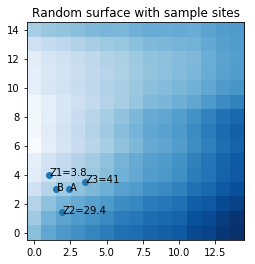

In [2]:
def moving_window(arr,w=(3,3)):
    # Runs a moving window attribute over a 2D array
    arr2 = arr.copy()
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            arr2[i,j] = arr[np.clip(i-w[0],0,arr.shape[0]):i+w[1],np.clip(j-w[1],0,arr.shape[1]):j+w[1]].mean()
    return arr2
    
def linear_transformation(arr,new_min=0,new_max=1):
    # Does linear transformation to whatever limits you might prefer.
    data = (arr-arr.min())*(new_max-new_min)**2/(arr.max()-arr.min())+new_min
    return data

samples = 100
limit   = 0.5
window  = (10,5)

# Interpolation of random data
np.random.seed(1) #1
res = 15 
arr = np.zeros((res,res))
hdx = np.random.randint(0,res,samples)
hdy = np.random.randint(0,res,samples)
arr[hdx,hdy] = 1

arr = moving_window(arr,w=(5,5))
arr = moving_window(arr,w=window)
arr = linear_transformation(arr,0,1) 

y = [4.0, 1.4, 3.5, 3.0, 3.0 ]
x = [1.0, 1.9, 3.5, 2.4, 1.5]
label = ['Z1=3.8', 'Z2=29.4', 'Z3=41', 'A', 'B']

fig, ax = plt.subplots()
ax.scatter(x, y)
ax.set_title('Random surface with sample sites')

for i, txt in enumerate(label):
    ax.annotate(txt, (x[i]+0.05, y[i]-0.05))
ax.imshow(arr.T, origin='lower',interpolation='nearest',cmap='Blues', norm=mc.Normalize(vmin=0, vmax=1))

### Calculating Semivariance  

The right-hand side of this equation is straightforward, consisting of the sum of the squares of all the pairs of height control point values at a given distance, divided by their number $n(d)$. In other words, it is simply their mean. The left-hand side of the equation uses the standard notation in which $\gamma$ is the conventional symbol for the semivariogram. 

(a)
$$\large{ \hat{\gamma}(d)= \frac{1}{n(d)}  \sum_{d_{ij}=d}(z_{i}-z_{j})^2}$$

In particular, for a given distance, more likely than not, there will be no pair of observations at precisely that separation. Therefore, as for the variogram cloud box plots, we make estimates for distance bins (or lags) rather than continuously at all distances. Thus, the above equation should really be rewritten as 

(b)
$$ \large{ \hat{\gamma}(d)= \frac{1}{n(d+\Delta/2)}  \sum_{d\pm  \Delta / 2}(z_{i}-z_{j})^2}$$

indicating that the estimate is made over pairs of observations whose separations lie in the range $d - \Delta / 2$ to $d + \Delta / 2$. It is also important to note that the form of the equations shown here depends only on the distance between observations, effectively assuming that the underlying phenomenon is isotropic.

Now we just need to calculate the components of the formula, and fit a model that reasonably describes it. 

### Calculate pair-wise distance & squared differences 

In this section we want to create a *squared root differences* cloud. This is simply the $(z_{i}-z_{j})^2$ for any point $z_{i}$ and any other point $z_{j}$. 

Since there are 15x15 cells, each point needs to be compared to the 224 other cells.

In [3]:
sqr_diff =  pd.DataFrame((arr - arr.swapaxes(0,1))**2)
print('Table A: Square difference between Zi and Zj')
sqr_diff.head()


Table A: Square difference between Zi and Zj


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.000000,0.026347,0.083155,0.186410,0.316324,0.380042,0.564282,0.547092,0.613940,0.619241,0.551664,0.655766,0.657690,0.586699,0.427277
1,0.026347,0.000000,0.017709,0.079079,0.171929,0.223936,0.374374,0.376397,0.441931,0.467110,0.427746,0.526973,0.537426,0.486070,0.352856
2,0.083155,0.017709,0.000000,0.021834,0.077455,0.114221,0.226296,0.235195,0.296406,0.332860,0.316932,0.404986,0.419651,0.385074,0.280299
3,0.186410,0.079079,0.021834,0.000000,0.016536,0.036390,0.107015,0.116353,0.164323,0.201639,0.203707,0.279697,0.299769,0.281503,0.205348
4,0.316324,0.171929,0.077455,0.016536,0.000000,0.004269,0.038210,0.045398,0.080134,0.117109,0.129701,0.193860,0.216767,0.209582,0.155271


We also keep track of the distance betwen $z_{i}$ and $z_{j}$ and store it as $d_{ij}$. 

In [4]:
raw_data_stack = pd.DataFrame(arr).stack().rename_axis(['y', 'x']).reset_index(name='val')
raw_dist = pd.DataFrame(squareform(pdist(raw_data_stack)))
print('Table B: Distances between Zi and Zj')
raw_dist.head()


Table B: Distances between Zi and Zj


,0,1,2,3,4,5,6,7,8,9,...,215,216,217,218,219,220,221,222,223,224
0,0.000000,1.001473,2.003360,3.008294,4.012586,5.011535,6.014953,7.011317,8.010333,9.008717,...,14.871688,15.236234,15.657313,16.128641,16.645296,17.205602,17.805141,18.439644,19.105586,19.799612
1,1.001473,0.000000,1.001900,2.007121,3.011528,4.010177,5.013639,6.009848,7.008866,8.007303,...,14.567583,14.872351,15.238000,15.658086,16.127514,16.644979,17.205885,17.805589,18.440255,19.106141
2,2.003360,1.001900,0.000000,1.005735,2.010133,3.008340,4.011832,5.007959,6.007041,7.005607,...,14.327435,14.568594,14.874648,15.239132,15.656911,16.127249,16.645471,17.206602,17.806527,18.441108
3,3.008294,2.007121,1.005735,0.000000,1.004439,2.003396,3.006702,4.003825,5.003366,6.002493,...,14.156251,14.330435,14.573092,14.877694,15.239104,15.657693,16.128876,16.647349,17.208765,17.808552
4,4.012586,3.011528,2.010133,1.004439,0.000000,1.000248,2.002823,3.001084,4.000994,5.000619,...,14.054451,14.159226,14.335252,14.576200,14.877155,15.239701,15.659512,16.131096,16.649970,17.211192


### Combine data and plot square root differences cloud

Now we can combine all the data and look at plotting. 

In [5]:
sqr_diff_stack = pd.DataFrame(sqr_diff).stack().rename_axis(['y', 'x']).reset_index(name='Sq_Diff')
raw_dist_stack = pd.DataFrame(raw_dist).stack().rename_axis(['y', 'x']).reset_index(name='Dist')

all_semi_data = pd.concat([raw_data_stack['val'],raw_dist_stack['Dist'],sqr_diff_stack['Sq_Diff']],axis=1)
all_semi_data['Dist_Bin'] = pd.cut(all_semi_data['Dist'], bins=range(-1,res+2,2), labels=range(0,res+2,2)[:-1])
print('Table C: Raster surface data by cell')
all_semi_data.head()


Table C: Raster surface data by cell


,val,Dist,Sq_Diff,Dist_Bin
0,0.423869,0.000000,0.000000,0
1,0.369563,1.001473,0.026347,2
2,0.307891,2.003360,0.083155,2
3,0.200641,3.008294,0.186410,4
4,0.106309,4.012586,0.316324,4


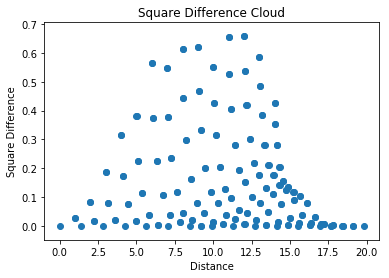

In [6]:
fig, ax = plt.subplots()
ax.scatter(all_semi_data['Dist'], all_semi_data['Sq_Diff'])
ax.set_title('Square Difference Cloud')
ax.set_xlabel('Distance')
ax.set_ylabel('Square Difference')


Cloud plots can be useful exploratory tools, but they are often difficult to interpret, largely because there are so many points. A more condensed summary is provided by subdividing the distance axis into intervals, called lags, and constructing a summary of the points in each distance interval. For each lag, we calculate a measure of central tendency (mean or median) and summarize the variation around this mean using box plots, one for each lag.

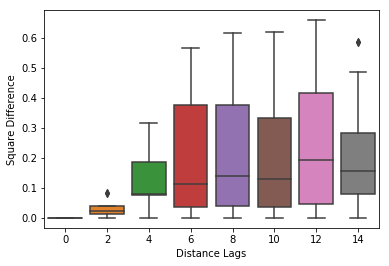

In [7]:
boxplot(x="Dist_Bin", y="Sq_Diff", data=all_semi_data)
plt.xlabel("Distance Lags")
plt.ylabel("Square Difference")


Looking above we can clearly see that the squared difference ($(z_{i}-z_{j})^2$) between points increases up to a distance of around 8 cells away, and then levels off. This maximum value could roughtly be considered the 'sill' and the range would be approximately '8' cells away.

We can also just plot the mean values by distance lag, and then try to fit semi-variogram model to best fit the data. 


(0, 0.4)

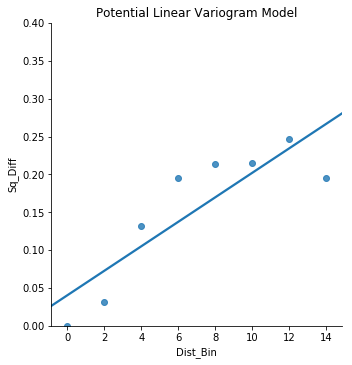

In [8]:
all_semi_data_mean = all_semi_data.groupby('Dist_Bin').agg({'Sq_Diff':np.mean}).reset_index()
#pointplot(x='Dist_Bin',y='Sq_Diff',data=all_semi_data,)

# Show the results of a linear regression within each dataset
lmplot(x="Dist_Bin", y="Sq_Diff",   data=all_semi_data_mean,order=1, ci=False)  
plt.title('Potential Linear Variogram Model')
plt.ylim(0,.4) 


Although this exercise is a simplification of calculating sample semivariance and fitting a variogram model, it will help motivate the remainder of the lesson.  

Although simplistic, we can use a linear model the describe how the squared differences change across different distance bands. Clearly other more complicated models could beter describe the relationship. It is however useful because an estimate of semi-variance $\gamma$ can be calculated as a simple linear function as follows:

$$ \hat{\gamma} = 0.02 + 0.025 \times{Distance}$$

So for any distance we can easily estimate gamma $\gamma$

$$ \hat{\gamma} = 0.02 + 0.025 \times{8} = 0.22$$ 


# Kriging by hand


# Primer
The following intro will walk you through the use of 'constrained' optimization for kriging. However the principals used here underly not only kriging, but regression analysis, and to a certain degree machine learning more generally.


Before we start lets [learn about and practice matrix multiplication](https://www.khanacademy.org/math/precalculus/precalc-matrices/multiplying-matrices-by-matrices/v/multiplying-a-matrix-by-a-matrix)

Let's learn about [contrained optimization](https://www.khanacademy.org/math/multivariable-calculus/applications-of-multivariable-derivatives/lagrange-multipliers-and-constrained-optimization/v/constrained-optimization-introduction) by watching the first video.

Optimization generally is the idea that we need to find values for x and y that maximize (or minimize some function). In the case of kriging we will be solving for a set of weights that minimizes the error between estimated values across sites and the actual values (minimizing the residuals)

## Solving for the optimal weights
In this exercise we are going to try to use simple kriging to estimate the value of a single unknown point A using data obtained at three known sites 1, 2 & 3.

Below we can see the points:

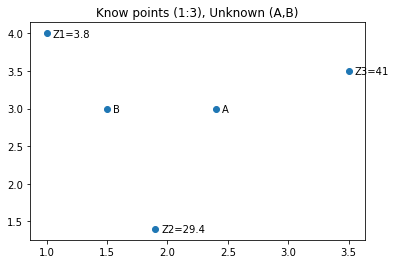

In [9]:
def plot_points():
    y = [4.0, 1.4, 3.5, 3.0, 3.0 ]
    x = [1.0, 1.9, 3.5, 2.4, 1.5]
    label = ['Z1=3.8', 'Z2=29.4', 'Z3=41', 'A', 'B']

    fig, ax = plt.subplots()
    ax.scatter(x, y)
    ax.set_title('Know points (1:3), Unknown (A,B)')

    for i, txt in enumerate(label):
        ax.annotate(txt, (x[i]+0.05, y[i]-0.05))
plot_points()

We wish to estimate a value for every unsampled location using a weighted sum of the z values from surrounding control points, that is,

(1) $$ \large{ \hat{z}_{s}= w_{1}z_{1}  + \ldots + w_{n}z_{n} =
\sum_{i=1}^n w_{i}z_{i} }$$ 


where $w_{1} \ldots w_{n}$ is a set of weights applied to sampled values in order to arrive at the estimated value.  The weight as determined by some function of the distance between any known point and the unknown point.

The challenge then is to find a way to solve for weights that minimize estimation error based on known locations and the distance between them.

It can be shown that the semivariance ($\gamma$, i.e. gamma) calculated using the distance between all pairs of points can be used to set up a system of equations that minimize estimated values for a known location. 

The equations can be used to solve for the optimal $w_{n}$ based on the distance between any two known points (where $d_{12}$ can represent the distance between points 1 and 2).  

$\gamma(d_{12})$ then is the calculated semivariance between the two known points 1 and 2.  $\gamma(d_{1p})$ is the semivariance calculated for the distance between a known point (1) and an unknown point (p) that we want to make a prediction for. 

Ignore the Lagrange multiplier $\lambda$ (used to compare tangency of two non-linear functions e.g. gradients)



(2)
$$w_{1}\gamma(d_{11})+w_{2}\gamma(d_{12})+ \ldots +w_{n}\gamma(d_{1n})+ \lambda = \gamma(d_{1p}) \\
\vdots \hspace{2cm}  \vdots \hspace{2cm}  \vdots \hspace{2cm} = \hspace{1cm}\vdots \\
w_{1}\gamma(d_{n1})+w_{2}\gamma(d_{n2})+ \ldots +w_{n}\gamma(d_{nn})+ \lambda = \gamma(d_{np}) \\
w_{1} \hspace{0.5cm}+\hspace{0.5cm} w_{2}\hspace{0.5cm} +\ldots + w_{n} + \hspace{0.25cm} 0  \hspace{1cm} = \hspace{1cm}1 $$

The last line $w_{1} +\ldots+ w_{m}+0= 1$ is a constraint that ensures that all weights sum to 1.  We also need to use something called the Lagrangian multiplier ($\gamma$), which is outside the scope of this exerise.


Looking at this same set of equation in matrix format as follows:

$$ \Large{A} \cdot  \Large{w}   \Large{=}    \Large{b}  $$

or we can look at the matrix contents as follows:

Equation A:

(3)
$$\begin{bmatrix} 
\gamma(d_{11}) & \gamma(d_{12}) & \ldots & \gamma(d_{1n}) & 1 \\ 
\vdots & \vdots & \vdots & \vdots & \vdots \\
\gamma(d_{n1}) & \gamma(d_{n2}) & \ldots & \gamma(d_{nn}) & 1\\
1 & 1 & \ldots & 1 & 0
\end{bmatrix}_{n \times n}
\cdot
\begin{bmatrix} w_{1} \\ \vdots \\ w_{n} \\ \lambda \end{bmatrix}_{n \times 1}
= 
\begin{bmatrix} \gamma(d_{1p}) \\ \vdots \\ \gamma(d_{np}) \\ 1 \end{bmatrix}$$


Keep in mind what we learned about matrix multiplication above. 

Note that $\large{A}$ is the semivariance $\gamma$ based on the distance bewtween all known points, $\large{w}$ are the weights we are trying to solve for, and $\large{b}$ is filled with $\gamma(d_{np})$, the semivariance of distances between a known point (n) and an unknown point (p). 

We can then solve for the w by multiplying both sides by its inverse $\large{A}^{-1}$, the equivalent of matrix division. 

(4)
$$  \Large{w}   \Large{=}    \Large{b} \cdot \Large{A}^{-1} $$

This gives us the weights we need to minimize error while meeting the contraint of $w_{1} +\ldots + w_{n}  = 1$

## Solve for a single unknown location

Now we will solve for the first unknown point (A) based on distance and semi-variance from all other unknown locations. 

Look again at the points:

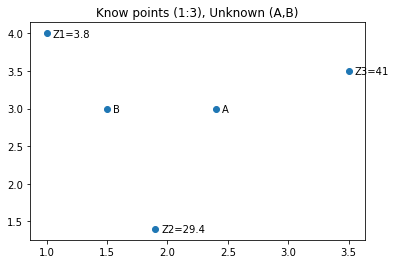

In [10]:
plot_points()

We can also put this in the format of a table of data with location and values:

In [11]:
data = {'x':[1.0,1.9,3.5,2.4,1.5],
        'y':[4.0,1.4,3.5,3.0,3.0],
        'value':[3.8,29.4,41.0,NaN,NaN]}

df = pd.DataFrame(data,index=[1,2,3,'A','B'])
print('Table A: Observations and points for predictions')
print(df)

Table A: Observations and points for predictions
   value    x    y
1    3.8  1.0  4.0
2   29.4  1.9  1.4
3   41.0  3.5  3.5
A    NaN  2.4  3.0
B    NaN  1.5  3.0


### Solve for weights matrix  $ \hspace{2cm} \normalsize{w}   \normalsize{=}    \normalsize{b} \cdot \normalsize{A}^{-1} $
#### Solve for matrix $A$

Matrix $\large{A}$ requires the distances ($d_{nn}$) between all points with known observations values and the semivariance ($\gamma$) associated with that distance.  Let's calculate the pair-wise distances between each point.

To start we are going to only look at the points with known values.

In [12]:
print('Table B: Locations with known values')
print(df.loc[[0,1,2],['x','y']])

Table B: Locations with known values
     x    y
1  1.0  4.0
2  1.9  1.4
3  3.5  3.5


In [13]:
print('Table C: Pairwise distances for points with observations')
dist = pd.DataFrame(squareform(pdist(df.loc[[0,1,2],['x','y']])),index=[1,2,3],columns=[1,2,3])
dist

Table C: Pairwise distances for points with observations


,1,2,3
1,0.000000,2.751363,2.549510
2,2.751363,0.000000,2.640076
3,2.549510,2.640076,0.000000


Now to create $\large{A}$ we need to calculate the semivariance $\gamma$ for the distance $d_{1,2}$ between point 1 and 2.

$$ \gamma(d_{1,2} = 2.75) = 0 + 60(2.75) = 165 $$

We can then make the calculations for all distances in Table C.

In [14]:
def semivar(d):
    sv = 0 + 60*d
    return sv

A = dist.apply(semivar)
print('Table D: Semivariance of distances between points 1, 2, 3')
A

Table D: Semivariance of distances between points 1, 2, 3


,1,2,3
1,0.000000,165.081798,152.970585
2,165.081798,0.000000,158.404545
3,152.970585,158.404545,0.000000


We now have all the $\gamma d_{nn}$ values for $\large{A}$ but need to put in the constraint, $w_{1}+ \ldots +w_{n} = 1$. This is done by adding a column of ones and a row of ones to our matrix of $\gamma d_{nn}$ values, each ending in zero. 


(5)
$$\begin{bmatrix} 
0.00 & 165.08  & 152.97 & 1 \\ 
165.08 & 0.00 & 158.40 & 1\\
152.97 & 158.40  & 0.00 & 1\\
1 & 1  & 1 & 0
\end{bmatrix}_{4 \times 4}
\cdot
\begin{bmatrix} w_{1} \\ \vdots \\ w_{n} \\ \lambda \end{bmatrix}_{4 \times 1}
= 
\begin{bmatrix} \gamma(d_{1p}) \\ \vdots \\ \gamma(d_{np}) \\ 1 \end{bmatrix}$$


Remember matrix multiplication. The row of ones are multiplied by the weights matrix $w$, and the 0 at the end of the row is multiplied by zero. The column of ones is multiplied each time by the lagrange multiplier ($\lambda$).

In [15]:
col1s = pd.DataFrame({'L':[1,1,1]},index=[1,2,3])
A = pd.concat([A,col1s],axis=1)
row1s = pd.Series([1,1,1,0],index=[1,2,3,'L'],name='L')
A = A.append(row1s,ignore_index=True)
A.columns=[1,2,3,'L']

#### Solve for matrix $A^{-1}$

Now we can solve for $\large{w}$ using the following:

$  \large{w}  \large{=} \large{b} \cdot \large{A}^{-1} $

The inverse of $\large{A}$, $\large{(A^{-1})}$ can be calculated as follows:

In [16]:
A_inv = pd.DataFrame(np.linalg.pinv(A), columns=A.columns, index=[1,2,3,'L'])
A_inv

,1,2,3,L
1,-0.004195,0.001937,0.002258,0.334850
2,0.001937,-0.004051,0.002114,0.345376
3,0.002258,0.002114,-0.004372,0.319774
L,0.334850,0.345376,0.319774,-105.931310


#### Solve for vector b

Now we can create the vector $\large{b}$ using the semivariance of distances between each of the three known points and the single unknown point we are trying to solve for (point a).

In [17]:
print('Table E: Distances from known points to point a')
data = pd.DataFrame(squareform(pdist(df[['x','y']])),index= [1,2,3,'A','B'],columns= [1,2,3,'A','B']).iloc[0:3,3]
Adist = pd.DataFrame( {'A':data})
Adist


Table E: Distances from known points to point a


,A
1,1.720465
2,1.676305
3,1.208305


With the same model for the semivariogram and augmented by the extra
row, this gives us values for the matrix b:

In [18]:
b = Adist.apply(semivar).append(pd.DataFrame({'A':[1]}))
b.index= [1,2,3,'L']
print('Table F: Vector b - Semivariances from known points to point a')
b


Table F: Vector b - Semivariances from known points to point a


,A
1,103.227903
2,100.578328
3,72.498276
L,1.000000


#### Solve for w

Now we just multiply $\large{b \cdot \large{A^{-1}}}$

In [19]:
w = pd.DataFrame(np.dot(A_inv, b),index = [1,2,3,'L'],columns=['w'])
w

,w
1,0.260336
2,0.291150
3,0.448513
L,-13.445046


Note that the weights all sum to 1. 

*We now have the weights to solve for our point a*

### Solve for the estimated value of point a

The value for point a can be solved for by doing a sum of the weights and the known values from points 1, 2 and 3. 

(6)
$$\hat{a} = \sum_{n=1}^{n} w_{i} z_{i} = 0.260(3.8) + 0.291(29.4) + 0.449(41.0) = 27.94$$

We can solve it using the dot product as well:

In [20]:
print(np.dot([3.8,29.4,41],w[0:3]))

[27.93814294]



We can more simply do calculations with 'linear algerbra'. Linear algebra is the branch of mathematics concerning linear equations such as. linear functions such as. and their representations through matrices and vector spaces. Linear algebra is central to almost all areas of mathematics.

The summation $\sum_{i=1}^n w_{i}z_{i}$ can also be thought of in terms of linear algerbra using 'matrix multiplication'. 

$$\sum_{i=1}^n w_{i}z_{i} = \mathbf{w}^{T}\mathbf{z}$$ 

We start by transposing $\mathbf{w}$, transposing simply rotates the matrix on the diagonal. 

So 

$$ \mathbf{w} = \begin{bmatrix}
  w_{11} & w_{12} \\
  w_{21} & w_{22}   
\end{bmatrix}_{2 \times 2}$$

Transposes to: 

$$ \mathbf{w}^{T} = \begin{bmatrix}
  w_{11} & w_{21} \\
  w_{12} & w_{22}   
\end{bmatrix}_{2 \times 2}$$

$$\mathbf{w}^{T}\mathbf{z} = 
\begin{bmatrix}
  w_{11} & w_{21} \\
  w_{12} & w_{22}   
\end{bmatrix}_{2 \times 2}
\times$$ 

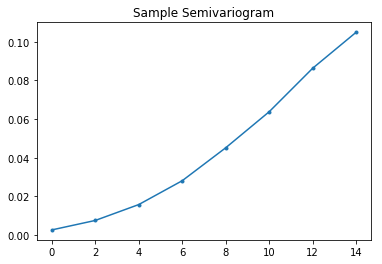

In [21]:
def SVh( P, h, bw ):
    '''
    Experimental semivariogram for a single lag
    '''
    pd = squareform( pdist( P[:,:2] ) )
    N = pd.shape[0]
    Z = list()
    for i in range(N):
        for j in range(i+1,N):
            if( pd[i,j] >= h-bw )and( pd[i,j] <= h+bw ):
                Z.append( ( P[i,2] - P[j,2] )**2.0 )
    return np.sum( Z ) / ( 2.0 * len( Z ) )
 
def SV( P, hs, bw ):
    '''
    Experimental variogram for a collection of lags
    '''
    sv = list()
    for h in hs:
        sv.append( SVh( P, h, bw ) )
    sv = [ [ hs[i], sv[i] ] for i in range( len( hs ) ) if sv[i] > 0 ]
    return np.array( sv ).T
 
    
# part of our data set recording porosity
P = np.array( raw_data_stack[['x','y','val']] )
# bandwidth, plus or minus 250 meters
bw = 2
# lags in 500 meter increments from zero to 10,000
hs = np.arange(0,15,bw)
sv = SV( P, hs, bw )

plt.plot(sv[0], sv[1], '.-'  )
plt.title('Sample Semivariogram')
plt.show()
 